# Advanced Portfolio Optimization and Risk Analysis

This notebook presents a workflow for constructing and analyzing an optimal investment portfolio. It demonstrates:
1. **Configuration & Data Pipeline**: Setting up parameters and processing market data using modern estimation techniques.
2.  **Interactive Optimization**: Finding optimal portfolio weights to maximize risk-adjusted returns.
3.  **Risk & Return Simulation**: Projecting future performance and assessing risk using Monte Carlo methods.

The core logic is encapsulated in the accompanying `.py` modules, keeping this notebook focused on the high-level analysis workflow and results.

## 1. Setup and Configuration

### 1.1. Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from ipywidgets import FloatSlider, IntSlider, interact

from portfolio_analyzer import input_preparator as ip
from portfolio_analyzer.backtester import Backtester
from portfolio_analyzer.config import AppConfig
from portfolio_analyzer.monte_carlo_simulator import MonteCarloSimulator
from portfolio_analyzer.plotting import (
    calculate_correlation_matrix,
    plot_correlation_heatmap,
    plot_correlation_network,
    plot_efficient_frontier,
    plot_optimal_weights,
    plot_simulation_distribution,
    plot_simulation_paths,
)
from portfolio_analyzer.portfolio_optimizer import PortfolioOptimizer
from portfolio_analyzer.reporting import (
    display_optimization_summary_html,
    display_simulation_summary_html,
)

sns.set_theme(style="whitegrid", palette="pastel")
sns.set_context("notebook")

### 1.2. Define Parameters
All key parameters are managed in the `AppConfig` class in `config.py`. This provides a centralized way to control tickers, date ranges, and model hyperparameters. User-specific views for the Black-Litterman model can also be defined here.

In [1]:
# --- General Model Configuration ---
config = AppConfig()

## 2. Data Pipeline & Input Preparation
The `input_preparator` module encapsulates the entire data preparation pipeline. It fetches historical prices and market capitalizations, calculates log returns, and prepares the final mean return vector and covariance matrix for optimization.

**New Feature**: If enabled, the pipeline now automatically runs a DCF calculation for each asset. These are used to generate views for the Black-Litterman model, providing forward-looking estimates of return. The model also incorporates a special rule: assets without a market capitalization will use their implied equilibrium return rather than the full Black-Litterman posterior return, blending market-neutral priors with forward-looking views.

The pipeline uses techniques like EWMA, Ledoit-Wolf shrinkage, and Black-Litterman blending to create robust and stable inputs.


In [2]:
try:
    # The prepare_model_inputs function now internally handles the creation
    # of DCF-based views if enabled in the config.
    model_inputs = ip.prepare_model_inputs(config)
    mean_returns = model_inputs.mean_returns
    cov_matrix = model_inputs.cov_matrix
    log_returns = model_inputs.log_returns
    close_df = model_inputs.close_df
    final_tickers = model_inputs.final_tickers
except Exception as e:
    print(f"Data pipeline failed: {e}. Cannot proceed with analysis.")
    mean_returns, cov_matrix, log_returns, close_df, final_tickers = (
        pd.Series(dtype=float),
        pd.DataFrame(),
        pd.DataFrame(),
        pd.DataFrame(),
        [],
    )

--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



1 Failed download:
['MULTI.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4208 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')




Proceeding with 17 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

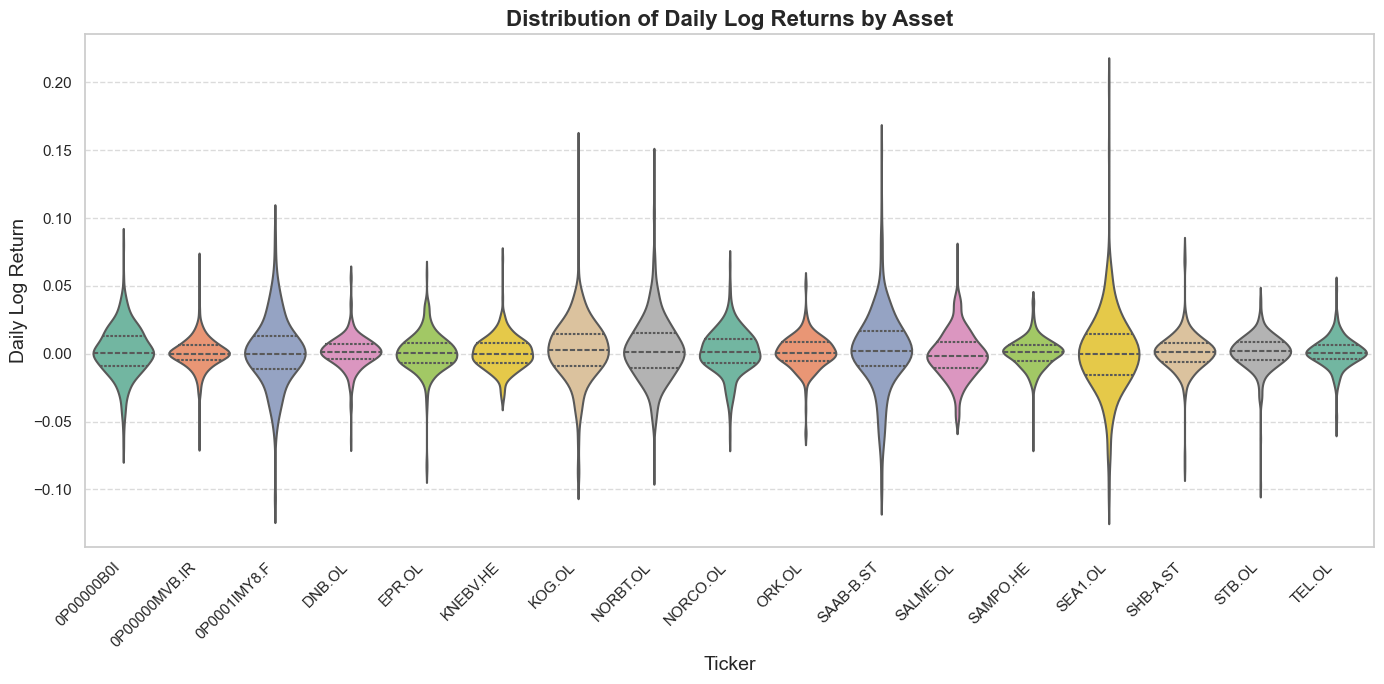

In [3]:
# Visualize the distribution of daily returns for the processed assets
plt.figure(figsize=(14, 7))
sns.violinplot(data=log_returns, palette="Set2", inner="quartile", linewidth=1.5)
plt.title("Distribution of Daily Log Returns by Asset", fontsize=16, fontweight="bold")
plt.xlabel("Ticker", fontsize=14)
plt.ylabel("Daily Log Return", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.7, axis="y")
plt.tight_layout()
plt.show()

### 2.1. Review Model Return Estimates
After running the pipeline, we can compare the different return estimates for our assets:
- **Historical (EWMA Shrunk)**: The backward-looking return, based on historical price movements.
- **Implied Equilibrium**: The forward-looking return implied by the market capitalization weights (i.e., what the market collectively assumes).
- **BL Posterior (Final)**: The final blended return from the Black-Litterman model, which combines the implied equilibrium returns with our DCF-based views. This is the vector that will be used for optimization.

In [4]:
if "model_inputs" in locals() and model_inputs and not model_inputs.mean_returns.empty:
    returns_df = pd.DataFrame(index=final_tickers)
    returns_df["Historical"] = model_inputs.hist_mean_returns

    if model_inputs.implied_equilibrium_returns is not None:
        returns_df["Implied Equilibrium"] = model_inputs.implied_equilibrium_returns

    returns_df["BL Posterior (Final)"] = model_inputs.mean_returns

    # Display the DataFrame, formatted as percentages
    display(
        returns_df.style.format("{:.2%}")
        .background_gradient(cmap="viridis", axis=0)
        .set_caption("Comparison of Annualized Return Estimates")
        .set_properties(**{"text-align": "right"})
        .highlight_max(axis=0, color="lightgreen")
        .highlight_min(axis=0, color="lightcoral")
    )
else:
    print("Model inputs not available. Cannot display return estimates.")

,Historical,Implied Equilibrium,BL Posterior (Final)
0P00000B0I,76.10%,3.41%,17.95%
0P00000MVB.IR,28.39%,0.28%,5.90%
0P0001IMY8.F,81.28%,2.58%,18.32%
DNB.OL,39.73%,5.01%,8.05%
EPR.OL,56.84%,1.19%,50.00%
KNEBV.HE,34.65%,2.61%,-1.99%
KOG.OL,97.00%,12.67%,25.64%
NORBT.OL,178.07%,5.46%,29.64%
NORCO.OL,22.60%,1.92%,5.27%
ORK.OL,10.23%,2.31%,3.94%


### Visualizing Asset Correlations
Before optimizing, we visualize the relationships between the selected assets. The correlation matrix and network graph help in understanding the diversification potential within the portfolio.


Displaying Clustered Correlation Heatmap:


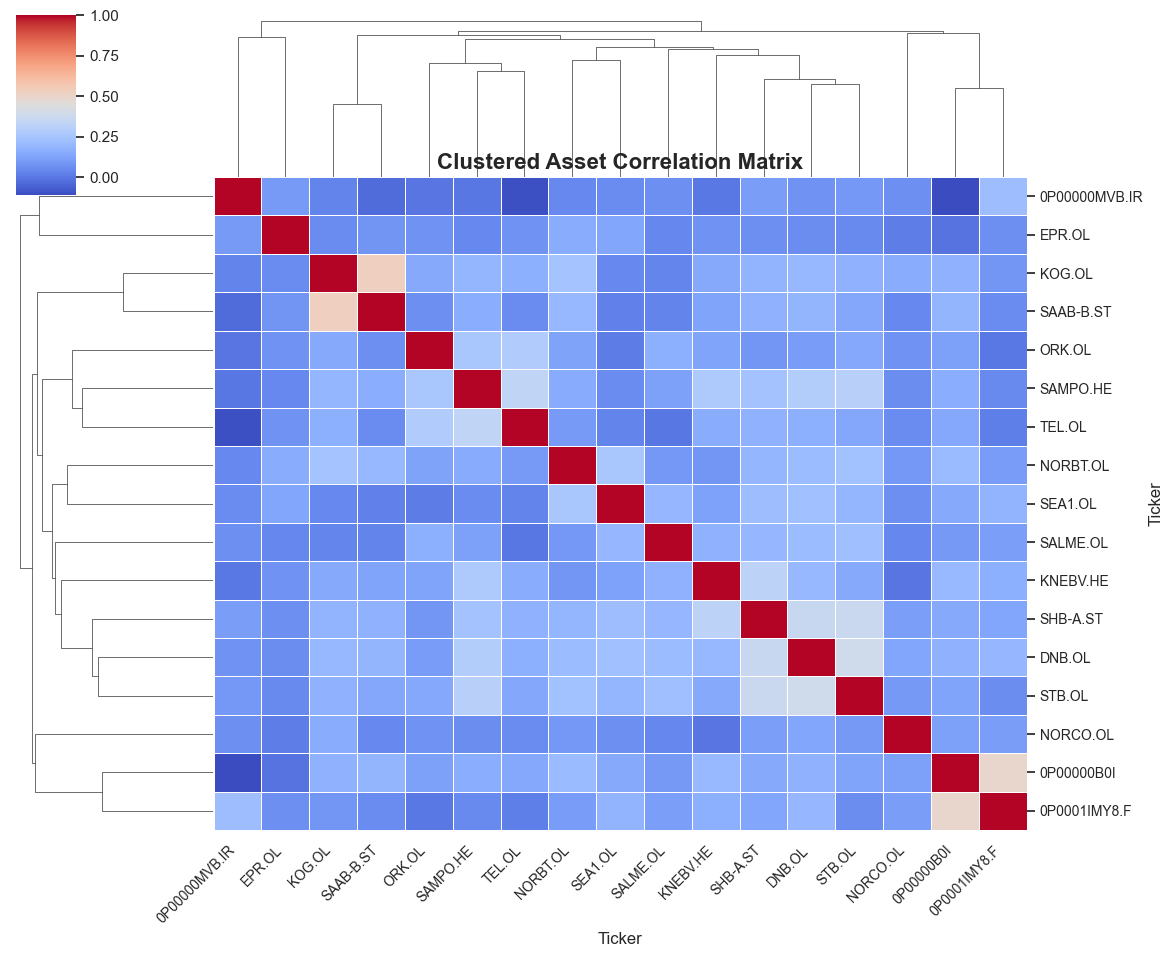


Displaying Correlation Network Graph:


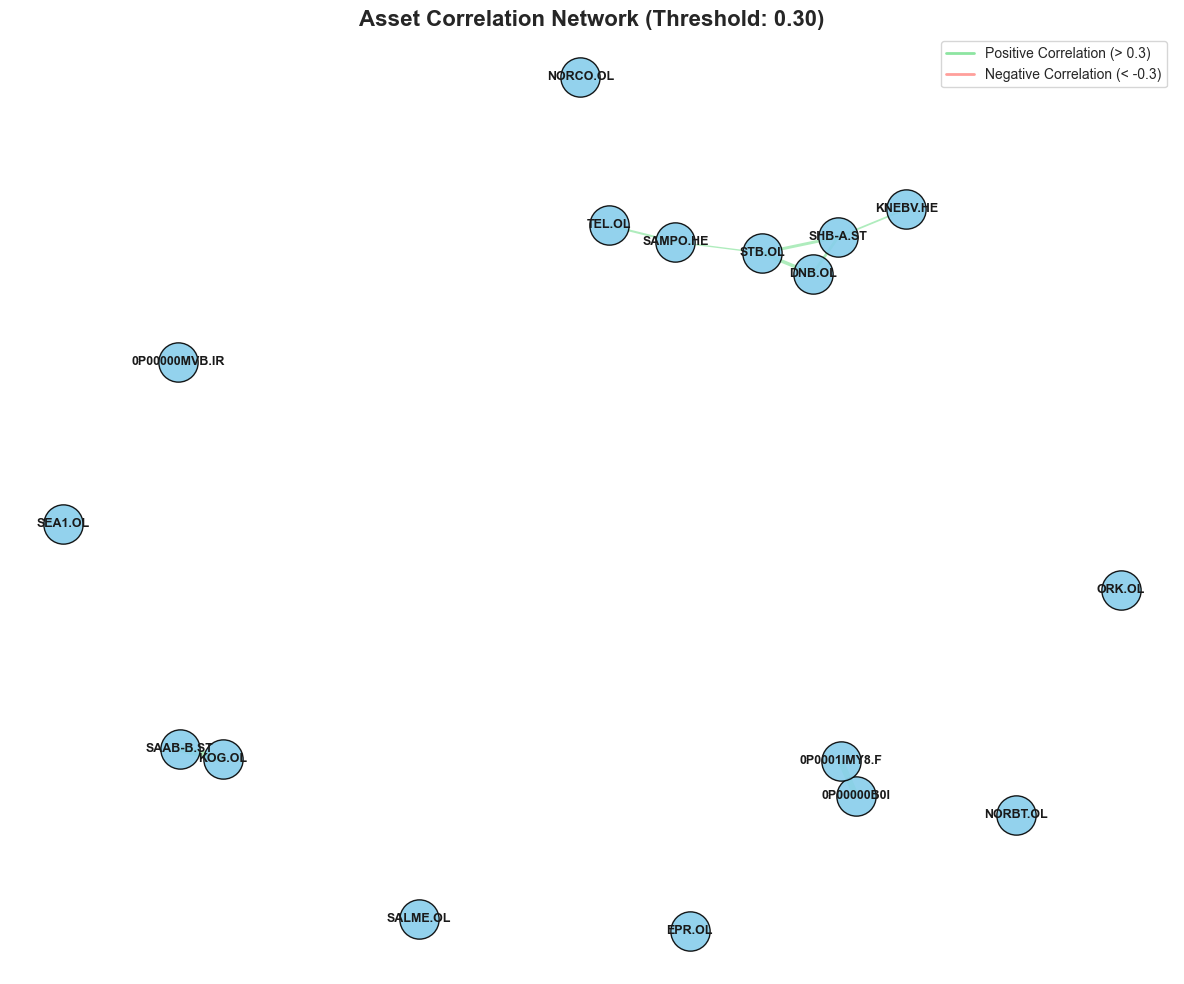

In [5]:
if not cov_matrix.empty:
    correlation_matrix_df = calculate_correlation_matrix(cov_matrix)

    plot_correlation_heatmap(correlation_matrix_df)
    plot_correlation_network(correlation_matrix_df, threshold=0.3)
else:
    print("Covariance matrix is empty. Skipping correlation plots.")

## 3. Interactive Portfolio Optimization
We now find the optimal portfolio weights by maximizing the risk-adjusted return (Sharpe Ratio), subject to constraints like maximum asset allocation. The L2 regularization parameter (`lambda_reg`) can be adjusted interactively to control for overfitting and encourage diversification.

In [6]:
# --- Initialize and run the interactive optimizer ---
if not mean_returns.empty:
    optimizer = PortfolioOptimizer(
        mean_returns=mean_returns,
        cov_matrix=cov_matrix,
        config=config,
    )

    def run_interactive_optimization(lambda_reg: float):
        """Wrap the interactive widget for portfolio optimization.

        Runs the optimization and displays results interactively.
        """
        # 1. Run the optimization
        result = optimizer.optimize(lambda_reg=lambda_reg)

        # 2. Display and plot the results
        if result and result.success:
            display(display_optimization_summary_html(result))
            plot_optimal_weights(result, config.optimization.max_weight_per_asset, lambda_reg)
        else:
            print("Optimization failed. Could not generate a valid portfolio.")

    interact(
        run_interactive_optimization,
        lambda_reg=FloatSlider(
            min=0.0,
            max=2.0,
            step=0.05,
            value=config.optimization.lambda_reg,
            description="L2 Lambda:",
            continuous_update=False,
            layout={"width": "500px"},
        ),
    )

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='L2 Lambda:', layout=Layout(…

## 4. Monte Carlo Simulation
To understand the potential future performance of the optimized portfolio, we run a Monte Carlo simulation. This projects thousands of possible future paths for the portfolio's value, helping to assess the range of potential outcomes. You can interactively adjust simulation parameters, including using a Student's t-distribution to better model extreme market events (fat tails).

In [7]:
mc_simulator = MonteCarloSimulator(config)


def run_interactive_monte_carlo(
    num_sim_interactive, time_horizon_interactive, df_t_interactive: int
) -> None:
    """Run an interactive Monte Carlo simulation for the optimized portfolio.

    Parameters
    ----------
    num_sim_interactive : int
        Number of simulation paths to generate.
    time_horizon_interactive : float
        Time horizon in years for the simulation.
    df_t_interactive : int
        Degrees of freedom for the Student's t-distribution (0-2 = Normal).

    """
    # Check if the optimizer object exists in the global scope and has a valid result.
    # The original check used `locals()`, which was incorrect for this scope.
    if "optimizer" not in globals() or not getattr(globals()["optimizer"], "latest_result", None):
        print("Optimization result not available. Please run the optimization widget first.")
        return

    latest_result = globals()["optimizer"].latest_result
    if not latest_result.success:
        print("Optimization was not successful. Cannot run simulation.")
        return

    try:
        # 1. Run the simulation to get the result object
        simulation_result = mc_simulator.run(
            portfolio_result=optimizer.latest_result,
            num_simulations=int(num_sim_interactive),
            time_horizon_years=time_horizon_interactive,
            df_t_distribution=int(df_t_interactive),
        )

        # 2. Pass the result object to the plotting functions
        display(display_simulation_summary_html(simulation_result))

        # 3. Create a combined plot dashboard
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle("Monte Carlo Simulation Dashboard", fontsize=20, fontweight="bold")

        plot_simulation_distribution(simulation_result, ax=axes[0])
        plot_simulation_paths(simulation_result, ax=axes[1])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
        plt.show()
        plt.close(fig)  # Explicitly close the figure to prevent re-rendering

    except Exception as e:
        print(f"An error occurred during simulation: {e}")


interact(
    run_interactive_monte_carlo,
    num_sim_interactive=IntSlider(
        min=1000,
        max=100000,
        step=1000,
        value=config.monte_carlo.num_simulations,
        description="Num Simulations:",
        continuous_update=False,
        layout={"width": "500px"},
        readout_format=",",
    ),
    time_horizon_interactive=FloatSlider(
        min=0.5,
        max=10.0,
        step=0.5,
        value=config.monte_carlo.time_horizon_years,
        description="Time Horizon (Yrs):",
        continuous_update=False,
        layout={"width": "500px"},
    ),
    df_t_interactive=IntSlider(
        min=0,
        max=30,
        step=1,
        value=config.monte_carlo.df_t_distribution,
        description="Student-t df (0-2=Normal):",
        continuous_update=False,
        layout={"width": "500px"},
    ),
);

interactive(children=(IntSlider(value=100000, continuous_update=False, description='Num Simulations:', layout=…

## 5. Efficient Frontier Analysis

The efficient frontier represents the set of optimal portfolios that offer the highest expected return for a defined level of risk (volatility). By plotting this frontier, we can visualize the trade-off between risk and return. We highlight two key portfolios on this frontier:
- **Maximum Sharpe Ratio Portfolio**: The portfolio that provides the best return per unit of risk (the tangency portfolio). This is the same portfolio found in the interactive optimization section.
- **Minimum Volatility Portfolio**: The portfolio with the lowest possible risk.


--- Efficient Frontier Analysis ---

Maximum Sharpe Ratio Portfolio:



Minimum Volatility Portfolio:


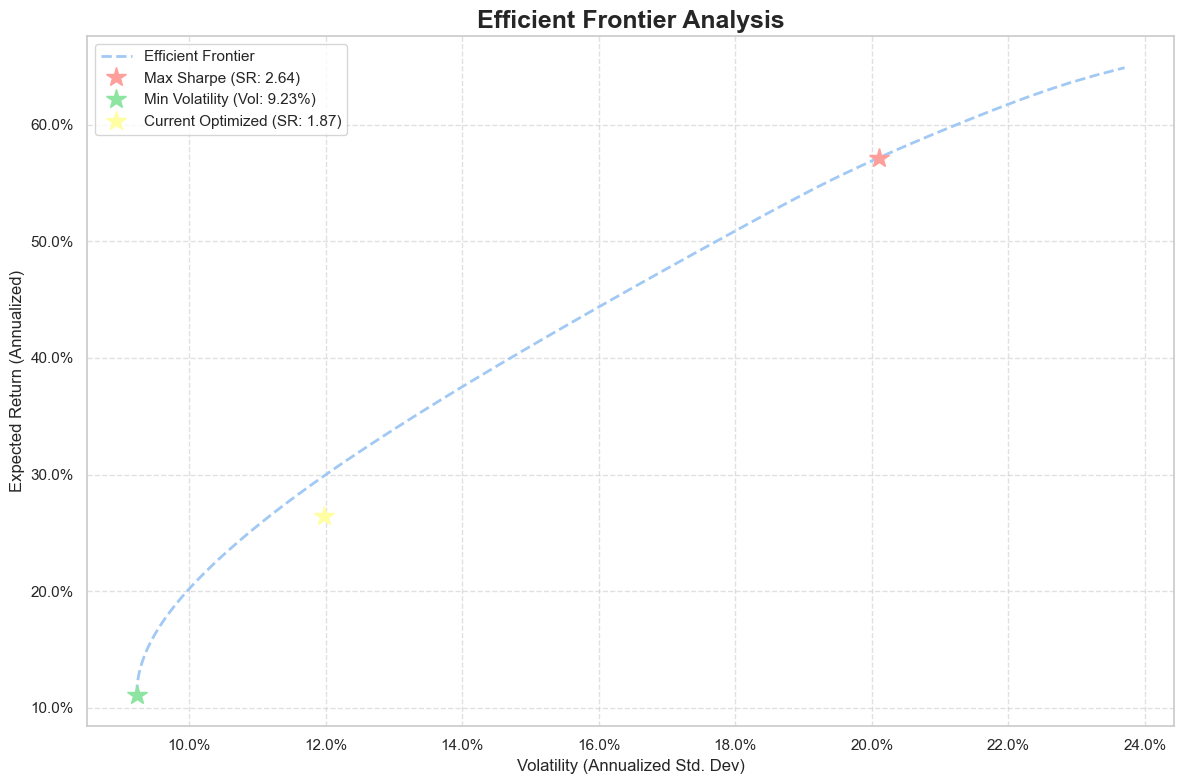

In [8]:
# --- Calculate and Plot the Efficient Frontier ---
print("\n--- Efficient Frontier Analysis ---")

if "optimizer" in globals() and optimizer:
    try:
        frontier_df, max_sharpe_res, min_vol_res = optimizer.calculate_efficient_frontier()

        print("\nMaximum Sharpe Ratio Portfolio:")
        display(display_optimization_summary_html(max_sharpe_res))

        print("\nMinimum Volatility Portfolio:")
        display(display_optimization_summary_html(min_vol_res))

        # Plot the efficient frontier
        plot_efficient_frontier(
            frontier_df,
            max_sharpe_res,
            min_vol_res,
            current_opt_result=optimizer.latest_result,
        )
    except Exception as e:
        print(f"Could not generate efficient frontier: {e}")
else:
    print("Optimizer not initialized. Please run the interactive optimization cell first.")

## 6. Strategy Backtesting

Finally, we perform a historical backtest to evaluate how the strategy would have performed over time. The backtester rebalances the portfolio at a fixed frequency (e.g., every 3 months), using a rolling lookback window to generate new optimization inputs at each step.


--- Running Backtest for 'Mean-Variance Optimization' ---
Fetching historical price data from yfinance...



3 Failed downloads:
['NORCO.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4191 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['0P00000B0I']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4194 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['SALME.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4190 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = pd.date_range(


Backtesting:   0%|          | 0/20 [00:00<?, ?it/s]

--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



6 Failed downloads:
['SALME.OL', 'NORCO.OL', '0P0001IMY8.F']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-07-01 -> 2020-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1498860000, endDate = 1593468000")')
['0P00000MVB.IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-07-01 -> 2020-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1498863600, endDate = 1593471600")')
['0P00000B0I']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-07-01 -> 2020-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1498881600, endDate = 1593489600")')
['SEA1.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4184 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')




Proceeding with 12 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:   5%|▌         | 1/20 [00:22<07:06, 22.47s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 12 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



7 Failed downloads:
['0P0001IMY8.F', 'SEA1.OL', 'NORCO.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-10-01 -> 2020-09-30) (Yahoo error = "Data doesn\'t exist for startDate = 1506808800, endDate = 1601416800")')
['ORK.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4213 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['SAAB-B.ST']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4243 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['0P00000B0I']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-10-01 -> 2020-09-30) (Yahoo error = "Data doesn\'t exist for startDate = 1506830400, endDate = 1601438400")')
['0P00000MVB.IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-1



Proceeding with 11 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  10%|█         | 2/20 [00:40<05:55, 19.75s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 11 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



5 Failed downloads:
['0P0001IMY8.F']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4249 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['NORCO.OL', 'SEA1.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2020-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1514761200, endDate = 1609369200")')
['0P00000B0I']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2020-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1609390800")')
['0P00000MVB.IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2020-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1514764800, endDate = 1609372800")')




Proceeding with 13 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  15%|█▌        | 3/20 [00:58<05:24, 19.09s/it]

  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 13 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



8 Failed downloads:
['NORCO.OL', 'SEA1.OL', '0P0001IMY8.F']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-04-01 -> 2021-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1522533600, endDate = 1617141600")')
['0P00000B0I']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-04-01 -> 2021-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1522555200, endDate = 1617163200")')
['0P00000MVB.IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-04-01 -> 2021-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1522537200, endDate = 1617145200")')
['DNB.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4223 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['EPR.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4232 ms:



Proceeding with 10 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  20%|██        | 4/20 [01:12<04:31, 16.99s/it]

--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



7 Failed downloads:
['NORCO.OL', '0P0001IMY8.F']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-07-01 -> 2021-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1530396000, endDate = 1625004000")')
['0P00000B0I']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-07-01 -> 2021-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1530417600, endDate = 1625025600")')
['0P00000MVB.IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-07-01 -> 2021-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1530399600, endDate = 1625007600")')
['SEA1.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4246 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['STB.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4253 ms: Could not



Proceeding with 11 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - Skipping NORBT.OL: Network or data error (Failed to perform, curl: (7) Failed to connect to query1.finance.yahoo.com port 443 after 4329 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.)
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Ski

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  25%|██▌       | 5/20 [01:30<04:20, 17.36s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 3 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 11 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



6 Failed downloads:
['0P00000MVB.IR']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2124 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['NORCO.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2106 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['MULTI.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2133 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['0P0001IMY8.F', 'SEA1.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-10-01 -> 2021-09-30) (Yahoo error = "Data doesn\'t exist for startDate = 1538344800, endDate = 1632952800")')
['0P00000B0I']: YFPricesMissingError('possibly delisted; no



Proceeding with 12 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  30%|███       | 6/20 [01:46<03:55, 16.84s/it]

  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 3 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 12 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



9 Failed downloads:
['0P00000MVB.IR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1546300800, endDate = 1640908800")')
['0P0001IMY8.F', 'SEA1.OL', 'NORCO.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1546297200, endDate = 1640905200")')
['SHB-A.ST']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2098 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['0P00000B0I']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2122 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['DNB.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2



Proceeding with 9 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential da

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  35%|███▌      | 7/20 [01:55<03:04, 14.23s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 9 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



8 Failed downloads:
['NORCO.OL', 'SEA1.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-04-01 -> 2022-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1554069600, endDate = 1648677600")')
['SHB-A.ST']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2105 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['SAAB-B.ST']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2097 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['NORBT.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2102 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['0P00000B0I']: ConnectionError('Failed to perform, curl: (7) Faile



Proceeding with 10 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  40%|████      | 8/20 [02:03<02:29, 12.46s/it]

--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



7 Failed downloads:
['NORCO.OL', 'SEA1.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-07-01 -> 2022-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1561932000, endDate = 1656540000")')
['EPR.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2108 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['STB.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2103 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['KNEBV.HE']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2105 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['NORBT.OL']: ConnectionError('Failed to perform, curl: (7) Failed to co



Proceeding with 11 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - Skipping NORBT.OL: Network or data error (Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2118 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.)
  - Skipping SAAB-B.ST: Network or data error (Failed to perform, curl: (7) Failed to connect to query1.finance.yahoo.com port 443 after 2092 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.)
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.O

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  45%|████▌     | 9/20 [02:16<02:16, 12.44s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 1 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 11 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



9 Failed downloads:
['NORCO.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-10-01 -> 2022-09-30) (Yahoo error = "Data doesn\'t exist for startDate = 1569880800, endDate = 1664488800")')
['SHB-A.ST', 'SAAB-B.ST']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2092 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['STB.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2097 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['SEA1.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 2090 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['EPR.OL', '0P0001IMY8.F']: ConnectionError('Failed to perform, curl:



Proceeding with 9 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - Skipping NORBT.OL: Network or data error (Failed to perform, curl: (7) Failed to connect to query1.finance.yahoo.com port 443 after 2115 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.)
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skip

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  50%|█████     | 10/20 [02:27<01:59, 11.97s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 2 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 9 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



2 Failed downloads:
['SEA1.OL', 'NORCO.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2022-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577833200, endDate = 1672441200")')




Proceeding with 16 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  55%|█████▌    | 11/20 [02:38<01:45, 11.72s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 16 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



4 Failed downloads:
['SEA1.OL', 'NORCO.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-03-31 -> 2023-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1585605600, endDate = 1680213600")')
['SAAB-B.ST']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4204 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['0P0001IMY8.F']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4219 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')




Proceeding with 14 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - Skipping NORBT.OL: Network or data error (Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4205 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.)
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Ski

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  60%|██████    | 12/20 [02:55<01:46, 13.37s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 3 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 14 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



3 Failed downloads:
['NORCO.OL', 'SEA1.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-30 -> 2023-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1593468000, endDate = 1688076000")')
['ORK.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4213 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')




Proceeding with 15 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  65%|██████▌   | 13/20 [03:06<01:28, 12.71s/it]

  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 15 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



4 Failed downloads:
['NORCO.OL', 'SEA1.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-09-30 -> 2023-09-30) (Yahoo error = "Data doesn\'t exist for startDate = 1601416800, endDate = 1696024800")')
['SHB-A.ST']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4200 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['0P00000MVB.IR']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4206 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')




Proceeding with 14 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  70%|███████   | 14/20 [03:17<01:12, 12.15s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 14 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



2 Failed downloads:
['SEA1.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-12-31 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1609369200, endDate = 1703977200")')
['SHB-A.ST']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4200 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')




Proceeding with 16 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  75%|███████▌  | 15/20 [03:30<01:02, 12.41s/it]

  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 16 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



1 Failed download:
['SEA1.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-04-01 -> 2024-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1617228000, endDate = 1711839600")')




Proceeding with 17 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  80%|████████  | 16/20 [03:41<00:48, 12.07s/it]

  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 4 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 17 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...

Proceeding with 18 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Fin

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  85%|████████▌ | 17/20 [03:50<00:33, 11.21s/it]

  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 5 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 18 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...

Proceeding with 18 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Fin

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  90%|█████████ | 18/20 [03:59<00:21, 10.54s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 5 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 18 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



1 Failed download:
['STB.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4222 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')




Proceeding with 17 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting:  95%|█████████▌| 19/20 [04:13<00:11, 11.32s/it]

  - Skipping 0P0001IMY8.F: Missing essential data (beta, mkt_cap, etc.).
  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 5 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 17 tickers.

--- Data Pipeline Finished ---
--- Starting Data Pipeline ---
Fetching market cap data from yfinance...
Fetching historical price data from yfinance...



1 Failed download:
['KOG.OL']: ConnectionError('Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 4263 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')




Proceeding with 17 tickers that have valid price data.
Successfully filtered and normalized market cap weights.

Calculating DCF-based views...
  - View for NORBT.OL: -25.80%
  - Skipping SAAB-B.ST: WACC (4.47%) is too close to perpetual growth rate (2.50%).
  - Skipping DNB.OL: Financial Sector company.
  - Skipping TEL.OL: WACC (4.82%) is too close to perpetual growth rate (2.50%).
  - Skipping ORK.OL: WACC (4.43%) is too close to perpetual growth rate (2.50%).
  - Skipping SAMPO.HE: Financial Sector company.
  - Skipping STB.OL: Financial Sector company.
  - View for SEA1.OL: -40.47%
  - Skipping SALME.OL: Negative 3-year average FCF (-559,350,000).
  - Skipping KOG.OL: WACC (5.31%) is too close to perpetual growth rate (2.50%).
  - View for KNEBV.HE: -26.00%
  - Skipping SHB-A.ST: Financial Sector company.
  - View for MULTI.OL: 100.00%
  - Skipping NORCO.OL: Missing essential data (beta, mkt_cap, etc.).
  - View for EPR.OL: 100.00%
  - Skipping 0P00000MVB.IR: Missing essential d

C:\Users\Aksel\Desktop\portfolio-analyzer\src\portfolio_analyzer\backtester.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_freq_offset = pd.tseries.frequencies.to_offset(
Backtesting: 100%|██████████| 20/20 [04:24<00:00, 13.23s/it]

  - Skipping 0P00000B0I: Missing essential data (beta, mkt_cap, etc.).

Constructing Black-Litterman views from DCF estimates...
Successfully constructed 5 views.

Attempting to run Black-Litterman model...
Successfully applied Black-Litterman model with views.

Blending final returns with 20% momentum.

Input preparation complete. Using 17 tickers.

--- Data Pipeline Finished ---


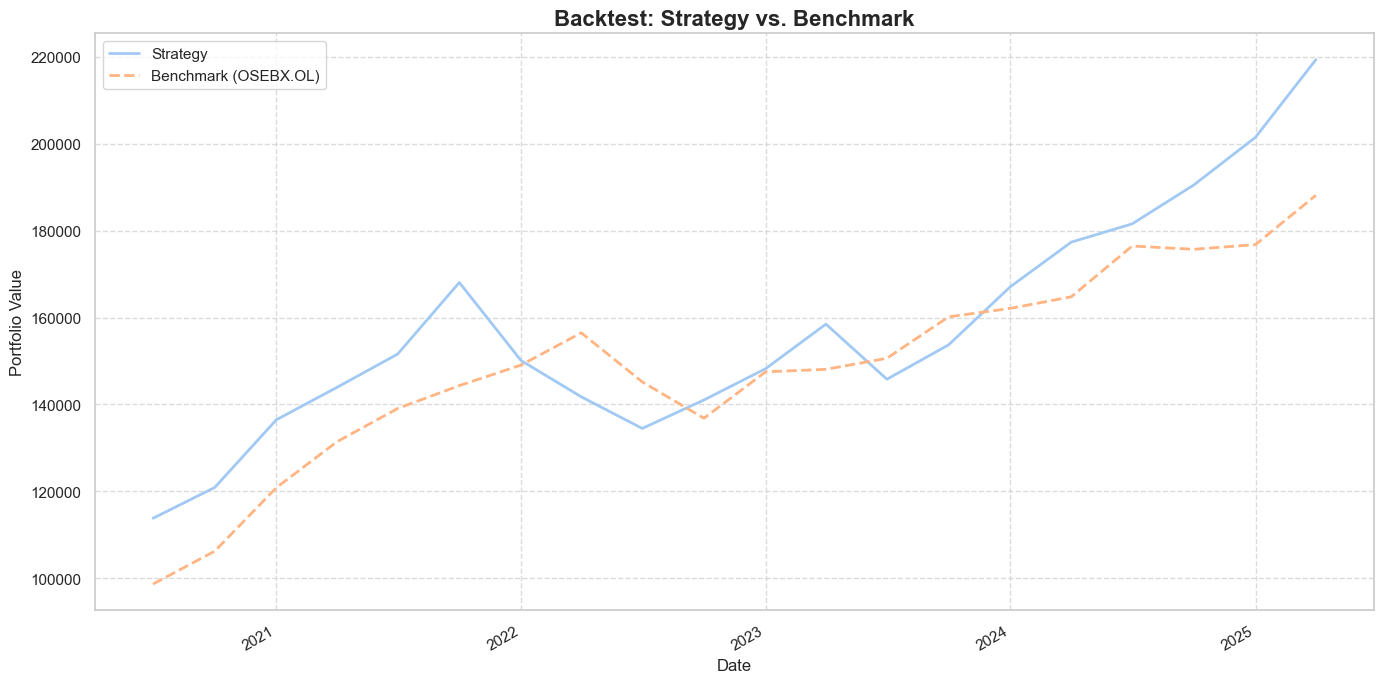

In [ ]:
# Define a benchmark index to compare against
# ^OSEBX is the Oslo Børs Benchmark Index
benchmark_ticker = "OSEBX.OL"

# Initialize and run the backtester
backtester = Backtester(config)
backtest_results = backtester.run(benchmark_ticker=benchmark_ticker)

clear_output(wait=True)

if not backtest_results.empty:
    # Plot the results
    plt.figure(figsize=(14, 7))
    backtest_results["Portfolio Value"].plot(linewidth=2, label="Strategy")

    if "Benchmark Value" in backtest_results.columns:
        backtest_results["Benchmark Value"].plot(
            linewidth=2, label=f"Benchmark ({benchmark_ticker})", linestyle="--"
        )

    plt.title("Backtest: Strategy vs. Benchmark", fontsize=16, fontweight="bold")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value", fontsize=12)
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Backtest did not produce any results.")